First, establish an ssh tunnel [with your PNI password] to jtb3-dev.princeton.edu to make the database available to you:

    ssh username@jtb3-dev.princeton.edu -L 3306:127.0.0.1:3306 -N

jtb3-dev is the database server on which all behavior and mouse data is stored. Second, make sure you have installed datajoint >= '0.12.dev3'
[ pip install datajoint==0.12.dev3 ]

In [2]:
import pylab as pl
import datajoint as dj
import numpy as np
import os,sys
import secrets
# assert dj.__version__>='0.12.dev3'
import pickle
from datetime import datetime
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import pandas as pd
import pkg_resources
from shutil import copyfile

home_dir = os.environ['HOME']

In [ ]:
dj.__versio`n__

In [ ]:
dj.config

In [11]:
dj.conn()

DataJoint connection (connected) ahoag@localhost:3306

In [3]:
schema = dj.create_virtual_module("ahoag_lightsheet_demo","ahoag_lightsheet_demo")

Please enter DataJoint username: ahoag
Please enter DataJoint password: ········
Connecting ahoag@localhost:3306


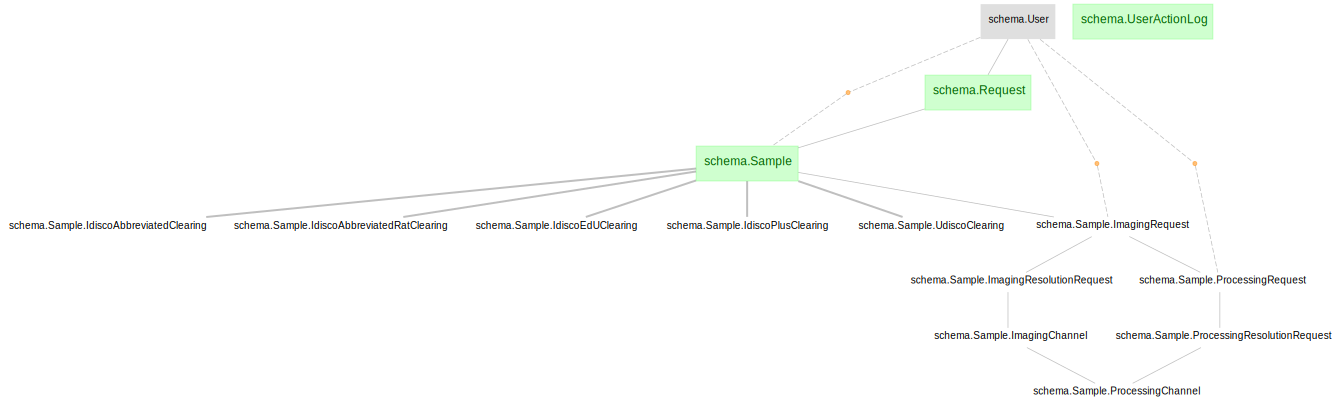

In [4]:
graph = dj.ERD(schema)
graph

In [19]:
graph.save('lightsheet_schema.png',format='png')

In [27]:
sample_contents = schema.Sample()

In [5]:
schema.Request()

username user in the lab,request_name,date_submitted The date it was submitted as a request,time_submitted The time it was submitted as a request,labname,correspondence_email,description,species,number_of_samples,sample_prefix,uniform_clearing,testing
ahoag,A really really really reallyreally really long title,2019-12-17,14:50:53,braincogs,ahoag@princeton.edu,test,mouse,1,sample,1,0
ahoag,test,2019-12-17,14:08:19,braincogs,ahoag@princeton.edu,test,mouse,1,sample,1,0
ahoag,test2,2019-12-17,17:09:24,braincogs,ahoag@princeton.edu,test,mouse,1,sample,0,0
kellyms,test_for_20191216,2019-12-16,14:48:19,wang,kellyms@princeton.edu,testing the website,mouse,22,m59876_an1_20191216,1,0


In [111]:
request_contents = schema.Request()
sample_contents = schema.Sample()
imaging_request_contents = schema.Sample().ImagingRequest()
processing_request_contents = schema.Sample().ProcessingRequest()

In [93]:
dj.U('username','request_name').aggr(request_contents * sample_contents,
                                     number_of_samples='number_of_samples',
                                     n_cleared='SUM(clearing_progress="complete")',
                                     fraction_cleared='n_cleared / number_of_samples')

TypeError: exceptions must derive from BaseException

TypeError: exceptions must derive from BaseException

In [108]:
sample_joined_contents = dj.U('username','request_name').aggr(request_contents * sample_contents,
                                     number_of_samples='number_of_samples',
                                     species='species',datetime_submitted='TIMESTAMP(date_submitted,time_submitted)',
                                     n_cleared='CONVERT(SUM(clearing_progress="complete"),char)').\
proj(fraction_cleared='CONCAT(n_cleared,"/",CONVERT(number_of_samples,char))',species='species',datetime_submitted='datetime_submitted',)  
sample_joined_contents

username user in the lab,request_name,species,datetime_submitted calculated attribute,fraction_cleared calculated attribute
ahoag,A really really really reallyreally really long title,mouse,2019-12-17 14:50:53,0/1
ahoag,test,mouse,2019-12-17 14:08:19,0/1
ahoag,test2,mouse,2019-12-17 17:09:24,0/1
kellyms,test_for_20191216,mouse,2019-12-16 14:48:19,22/22


In [112]:
imaging_joined_contents = dj.U('username','request_name').aggr(
    sample_joined_contents * imaging_request_contents,
    species='species',
    datetime_submitted='datetime_submitted',
    fraction_cleared='fraction_cleared',
    n_imaged='CONVERT(SUM(imaging_progress="complete"),char)',
    total_imaging_requests='CONVERT(COUNT(*),char)'
    ).proj(
        species='species',
        datetime_submitted='datetime_submitted',
        fraction_cleared='fraction_cleared',
        fraction_imaged='CONCAT(n_imaged,"/",total_imaging_requests)'
        )



In [117]:
dj.U('username','request_name').aggr(
    imaging_joined_contents * processing_request_contents,
    species='species',
    datetime_submitted='datetime_submitted',
    fraction_cleared='fraction_cleared',
    fraction_imaged='fraction_imaged',
    n_processed='CONVERT(SUM(processing_progress="complete"),char)',
    total_processing_requests='CONVERT(COUNT(*),char)'
    ).proj(
        species='species',
        datetime_submitted='datetime_submitted',
        fraction_cleared='fraction_cleared',
        fraction_imaged='fraction_imaged',
        fraction_processed='CONCAT(n_processed,"/",total_processing_requests)'
        )



username user in the lab,request_name,species,datetime_submitted calculated attribute,fraction_cleared calculated attribute,fraction_imaged calculated attribute,fraction_processed calculated attribute
ahoag,A really really really reallyreally really long title,mouse,2019-12-17 14:50:53,0/1,0/1,0/1
ahoag,test,mouse,2019-12-17 14:08:19,0/1,0/1,0/1
ahoag,test2,mouse,2019-12-17 17:09:24,0/1,0/1,0/1
kellyms,test_for_20191216,mouse,2019-12-16 14:48:19,22/22,1/25,0/25


In [114]:
processing_joined_contents

TypeError: exceptions must derive from BaseException

TypeError: exceptions must derive from BaseException

In [13]:
# Need to capture:
# clearing progress - Sample()
# imaging progress for all imaging requests - ImagingRequest()
# processing progress for all processing requests - ProcessingRequest()
request_name = 'test_for_20191216'
sample_contents = schema.Sample() & f'request_name="{request_name}"'
all_samples_clearing_progress = sample_contents.fetch('clearing_progress')

In [14]:
number_of_samples = len(all_samples_clearing_progress)
n_cleared = len([progress for progress in all_samples_clearing_progress if progress=='complete'])

In [18]:
imaging_request_contents = schema.Sample().ImagingRequest() & f'request_name="{request_name}"'
number_of_imaging_requests = len(imaging_request_contents)
all_requests_imaging_progress = imaging_request_contents.fetch('imaging_progress')
n_imaged = len([progress for progress in all_requests_imaging_progress if progress=='complete'])

1

In [20]:
processing_request_contents = schema.Sample().ProcessingRequest() & f'request_name="{request_name}"'
number_of_processing_requests = len(processing_request_contents)
all_requests_processing_progress = processing_request_contents.fetch('processing_progress')
n_processed = len([progress for progress in all_requests_processing_progress if progress=='complete'])
n_processed

0

In [19]:
from datajoint.table import Log               # Import Log table
logger = Log(dj.conn(), database='ahoag_lightsheet_demo') # Initialize logger
# logger('Custom event string.')                # Log message
# q = logger & 'event="Custom event string."'   # Query logger
# q.fetch1('timestamp')                         # Fetch logger
logger

timestamp,version datajoint version,user user@host,host system hostname,event custom message
2019-12-16 14:31:05,0.12.dev7py,ahoag@localhost,braincogs00.pni.princeton.edu,Declared `ahoag_lightsheet_demo`.`~log`
2019-12-16 14:31:06,0.12.dev7py,ahoag@localhost,braincogs00.pni.princeton.edu,Declared `ahoag_lightsheet_demo`.`#user`
2019-12-16 14:31:07,0.12.dev7py,ahoag@localhost,braincogs00.pni.princeton.edu,Declared `ahoag_lightsheet_demo`.`sample__idisco_plus_clearing`
2019-12-16 14:31:12,0.12.dev7py,ahoag@localhost,braincogs00.pni.princeton.edu,connect
2019-12-16 14:31:14,0.12.dev7py,ahoag@localhost,braincogs00.pni.princeton.edu,connect
2019-12-17 09:46:04,0.12.2py,ahoag@localhost,PNI-192QMG3Y2,connect
2019-12-17 09:46:05,0.12.2py,ahoag@localhost,PNI-192QMG3Y2,connect
2019-12-17 09:47:40,0.12.dev7py,ahoag@localhost,braincogs00.pni.princeton.edu,connect
2019-12-17 09:47:42,0.12.dev7py,ahoag@localhost,braincogs00.pni.princeton.edu,connect
2019-12-17 09:49:29,0.12.2py,ahoag@localhost,PNI-192QMG3Y2,connect


In [9]:
pd.DataFrame(logger.fetch())

,timestamp,version,user,host,event
0,2019-12-15 09:09:27,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_demo`.`~log`
1,2019-12-15 09:09:28,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,created
2,2019-12-15 09:09:29,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_demo`.`request`
3,2019-12-15 09:09:30,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_demo`.`sample`
4,2019-12-15 09:09:31,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_demo`.`sample__imag...
5,2019-12-15 09:09:32,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_demo`.`sample__imag...
6,2019-12-15 09:09:33,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_demo`.`sample__imag...
7,2019-12-15 09:09:34,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_demo`.`sample__proc...
8,2019-12-15 09:09:35,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_demo`.`sample__proc...
9,2019-12-15 09:09:36,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_demo`.`sample__proc...


In [38]:
logger.fetch(as_dict=True)[-1]

{'timestamp': datetime.datetime(2019, 12, 15, 9, 24, 26),
 'version': '0.12.1py',
 'user': 'ahoag@localhost',
 'host': 'vpn10-client-128-112-67-13.princeton.edu',
 'event': 'ms81 GET request to route: "home" in lightserv.main.routes'}

In [33]:
logger & 'timestamp > "2019-12-15 09:09:38"'

timestamp,version datajoint version,user user@host,host system hostname,event custom message
2019-12-15 09:15:28,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_test`.`~log`
2019-12-15 09:15:29,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_test`.`#user`
2019-12-15 09:15:30,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_test`.`request`
2019-12-15 09:15:31,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_test`.`sample`
2019-12-15 09:15:32,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_test`.`sample__imaging_request`
2019-12-15 09:15:33,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_test`.`sample__imaging_resolution_request`
2019-12-15 09:15:34,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_test`.`sample__processing_request`
2019-12-15 09:15:35,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_test`.`sample__processing_resolution_request`
2019-12-15 09:15:36,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_test`.`sample__processing_channel`
2019-12-15 09:15:37,0.12.1py,ahoag@localhost,vpn10-client-128-112-67-13.princeton.edu,Declared `ahoag_lightsheet_test`.`sample__idisco_plus_clearing`


In [ ]:
schema.Request()

In [ ]:
sample_contents = schema.Sample() 
sample_contents

In [ ]:
schema.

In [ ]:
schema.Sample.ImagingResolutionRequest()

In [ ]:
processing_request_contents = schema.Sample.ProcessingRequest()
processing_request_contents

In [ ]:
dj.Table._update(processing_request_contents & 'processing_request_number=1','processing_progress','incomplete')

In [ ]:
schema.Sample.ProcessingResolutionRequest()

In [ ]:
processing_contents = schema.Sample.ProcessingRequest()
processing_contents

In [ ]:
dj.Table._update(processing_contents,'processing_progress','incomplete')

In [ ]:
schema.Sample.ProcessingRequest()

In [ ]:
dj.Table._update(schema.Sample.ImagingRequest(),'processing_progress','not started')

In [ ]:
request_name = 'test'
sample_name = 'sample-001'
username = 'ahoag'
imaging_request_number = 1
processing_request_number = 1

In [ ]:
schema.Sample.ProcessingRequest() & f'request_name="{request_name}"' & \
			f'username="{username}"' & f'sample_name="{sample_name}"' & \
			 f'imaging_request_number="{imaging_request_number}"' & \
			 f'processing_request_number="{processing_request_number}"'

In [ ]:
schema.Sample.ImagingRequest()

In [ ]:
schema.Sample.ImageResolutionRequest()

In [ ]:
channel_contents=schema.Sample.ImagingChannel()

In [ ]:
channel_contents * processing_contents

In [ ]:
schema.Sample.ImagingChannel()

In [ ]:
schema.Sample()

In [ ]:
schema.Sample.IdiscoAbbreviatedClearing()

In [ ]:
sample_contents = schema.Sample & 'request_name="test6"' & 'username="ahoag"' 
sample_contents

In [ ]:
l=[1,2]
try:
    a = l[3]
except Exception as e:
    print(e)

In [ ]:
sample_contents.fetch1('antibody1','antibody2')

In [ ]:
dj.Table._update?

In [ ]:
resolution_dict = {'image_resolution': '1.3x', 'channels': [{'channel_name': '488', 'registration': False, 'injection_detection': False, 'probe_detection': False, 'cell_detection': False, 'csrf_token': ''}, {'channel_name': '555', 'registration': False, 'injection_detection': False, 'probe_detection': False, 'cell_detection': False, 'csrf_token': ''}, {'channel_name': '647', 'registration': False, 'injection_detection': False, 'probe_detection': False, 'cell_detection': False, 'csrf_token': ''}, {'channel_name': '790', 'registration': False, 'injection_detection': False, 'probe_detection': False, 'cell_detection': False, 'csrf_token': ''}], 'notes_for_imager': '', 'notes_for_processor': '', 'atlas_name': 'allen_2017', 'csrf_token': ''}

In [ ]:
all_imaging_modes = ['registration','injection_detection','probe_detection','cell_detection']
channels = resolution_dict['channels']
[item for subdict in channels for item in subdict if item in all_imaging_modes and subdict[item]==False]

In [ ]:
insert_dict = {'username': 'ahoag',
  'experiment_name': 'test2',
  'sample_name': 'sample-001',
  'image_resolution': '1.3x',
  'channel_name': '488',
  'imaging_request_number': 2,
  'registration': 1,
  'injection_detection': 0,
  'probe_detection': 0,
  'cell_detection': 0,
  'notes_for_imager': '',
  'notes_from_imaging': '',
  'atlas_name': 'allen_2017',
  'notes_for_processor': '',
  'tiling_scheme': '1x1',
  'tiling_overlap': 0.0,
  'z_step': 10,
    }

In [ ]:
exp_contents = schema.Experiment()
exp_contents

In [ ]:
sample_contents = schema.Sample()
sample_contents

In [ ]:
channel_contents = schema.Sample.ImagingChannel()
channel_contents

In [ ]:
combined_contents = dj.U('experiment_name','sample_name','imaging_request_number').aggr(
    channel_contents & 'experiment_name="test2"') * exp_contents
combined_contents

In [ ]:
combined_contents = dj.U('experiment_name','username','sample_name','imaging_request_number').aggr(channel_contents, 
        image_resolution='min(image_resolution)') * sample_contents * exp_contents
combined_contents

In [ ]:
dj.U('experiment_name','username','sample_name','imaging_request_number').aggr(channel_contents,imaging_progress='imaging_progress',
        image_resolution='min(image_resolution)')

In [ ]:
all_contents_unique_imaging_request_number = combined_contents.proj('imaging_request_number',
		'clearing_progress','clearer','imager',datetime_submitted='TIMESTAMP(date_submitted,time_submitted)')

In [ ]:
all_contents_unique_imaging_request_number

In [ ]:
schema.Sample.ImagingChannel().insert1(insert_dict)

In [ ]:
TestTable().insert1({'someval':4})

In [ ]:
TestTable()

In [ ]:
schema.Experiment()

In [ ]:
schema.Sample()

In [ ]:
schema.Sample.ImagingChannel()

In [ ]:
rs=sorted(list(set(schema.Sample.ImagingChannel().fetch('image_resolution'))))

In [ ]:
for ii in range(len(rs)):
    r = rs[ii]
    print(r)

In [ ]:
channel_contents =schema.Sample.ImagingChannel()

In [ ]:
channel_contents & 'image_resolution="1.3x"'

In [ ]:
schema.Sample.ProcessingChannel()

In [ ]:
'4'.zfill(3)

In [ ]:
os.path.join('test','this','out')

In [ ]:
sample_contents = schema.Sample() 
sample_contents

In [ ]:
channel_contents=schema.Sample.ImagingChannel() 
channel_contents

In [ ]:
dict_list=channel_contents.fetch(as_dict=True)
dict_list

In [ ]:
dict_list = [{'channel_name':'555','otherkey':'otherval1'},{'channel_name':'488','otherkey':'otherval2'}]
sorted(dict_list,key = lambda x: x['otherkey'])

In [ ]:
sample_contents * channel_contents

In [ ]:
dj.ERD(schema)

In [ ]:
schema.Sample.ImagingChannel()

In [ ]:
sample_contents * channel_contents

In [ ]:
channel_contents.fetch(as_dict=True)

In [ ]:
insert_list = [{'username':'ahoag','experiment_name':'test','sample_name':'sample-001','channel_name':'488'}]

In [ ]:
insert_list = [
    {'experiment_name': '3test', 'username': 'ahoag', 'sample_name': 'sample-001',
     'channel_name': '488', 'image_resolution_requested': '1.3x', 'registration': True, 
     'injection_detection': False, 'probe_detection': False, 'cell_detection': False},
    {'experiment_name': '3test', 'username': 'ahoag', 'sample_name': 'sample-001', 
     'channel_name': '555', 'registration': False, 'injection_detection': False, 
     'probe_detection': False, 'cell_detection': False}, 
    {'experiment_name': '3test', 'username': 'ahoag', 'sample_name': 'sample-001', 
     'channel_name': '647', 'registration': False, 'injection_detection': False, 
     'probe_detection': False, 'cell_detection': False}, 
    {'experiment_name': '3test', 'username': 'ahoag', 'sample_name': 'sample-001',
     'channel_name': '790', 'registration': False, 'injection_detection': False,
     'probe_detection': False, 'cell_detection': False}]


In [ ]:
schema.Sample.ImagingChannel().insert(insert_list)

In [ ]:
exp_contents

In [ ]:
(exp_contents * samples_contents).proj()

In [ ]:
(exp_contents * samples_contents)

In [ ]:
exp_contents.proj(datetime='TIMESTAMP(date_submitted,time_submitted)')

In [ ]:
schema = dj.create_virtual_module("ahoag_lightsheet_demo","ahoag_lightsheet_demo")

In [ ]:
schema.Sample()

In [ ]:
var='abc'
foo='bar'

In [ ]:

schema.Sample().fetch?

In [ ]:
ng = (f"this is an {var} "
      f"implicitly joined {foo} string")
ng

In [ ]:
mystr = 'channel488_registration'
mystr[0:6]

In [ ]:
import os

In [ ]:
mkdir "test


In [ ]:
sample_contents = schema.Sample() & 'sample_name ="test-1"'

In [ ]:
sample_dict=sample_contents.fetch

In [ ]:
Sample = schema.Sample()

In [ ]:
contents = schema.Sample()

In [ ]:
contents2=contents & 'sample_name="nothing"'

In [ ]:
contents2.heading.attributes.keys()


In [ ]:
Sample.heading.attributes.keys()

In [ ]:
sample_dict

In [ ]:
l1=[0,0,1]
any(l1)

In [ ]:
[key for key in sample_dict.keys() if key[0:10]=='channel488']

In [ ]:
schema = dj.create_virtual_module("ahoag_microscope_demo","ahoag_microscope_demo")

In [ ]:
schema.Microscope()

In [ ]:
schema.Experiment

In [ ]:
user=schema.User()

In [ ]:
user_contents = user & 'username="ahoag"'
user_contents

In [ ]:
frame = pd.DataFrame(user_contents.fetch())
frame.username

In [ ]:
insert_dict =  {'username':'ahoag','experiment_name':'Test','sample_name':'t-1','exp_notes':'notes'}
schema.Sample.IdiscoAbbreviatedClearing().insert1(insert_dict)

In [ ]:
schema.Sample.IdiscoAbbreviatedClearing().insert1()

In [ ]:
user_contents=schema.User()

In [ ]:
username='ahoag'
experiment_name='test3'

In [ ]:
schema.Experiment()

In [ ]:
schema.Experiment() & f'username="{username}"' & f'experiment_name="{experiment_name}"'

In [ ]:
schema.Experiment().Sample() & f'username="{username}"' & f'experiment_name="{experiment_name}"'

In [ ]:
schema.Experiment.Sample()

In [ ]:
schema.Experiment()

In [ ]:
# schema = dj.schema('ahoag_lightsheet_demo')
schema = dj.create_virtual_module('ahoag_microscope_demo','ahoag_microscope_demo')

In [ ]:
schema.Microscope().fetch('microscope_name')

In [ ]:
schema.Channel().fetch("KEY")

In [ ]:
schema.Laser().fetch("KEY")[0].keys()

In [ ]:
schema.Laser()

In [ ]:
insert_dict = {'laser_name':'Test laser','laser_model':'new model','laser_serial':'new serial'}
primary_key_list = schema.Laser().primary_key
primary_key_list

In [ ]:
# primary_key_result_str = ''

primary_key_result_str =','.join(f'{key} = {insert_dict[key]}' for key in primary_key_list)
primary_key_result_str

In [ ]:
insert_dict = {'microscope_name':'light sheet microscope','channel_name':'test'}
primary_key_list = schema.Channel().primary_key
primary_key_list

In [ ]:
primary_key_result_str =', '.join(f'{key} = {insert_dict[key]}' for key in primary_key_list)
primary_key_result_str

In [ ]:
schema.Microscope()

In [ ]:
UdiscoClearing().drop()

## 1) Define database tables

In [ ]:
@schema
class User(dj.Lookup):
    definition = """
    # Users of the light sheet microscope
    username : varchar(20)      # user in the lab
    ---
    email       : varchar(50)
    """
    
@schema
class Experiment(dj.Manual):
    definition = """ # Experiments performed using the light sheet microscope
    experiment_id           :   smallint auto_increment    # allowed here are sql datatypes.
    ----
    -> User 
    title                   :   varchar(100)
    description             :   varchar(250)
    notes = ""              :   varchar(1000)
    species                 :   varchar(50)
    clearing_protocol       :   enum("iDISCO+_immuno","iDISCO abbreviated clearing","iDISCO abbreviated clearing (rat)","uDISCO","iDISCO_EdU")
    clearing_progress       :   enum("incomplete","complete")
    fluorophores            :   varchar(100)
    antibody1               :   varchar(100)
    antibody2               :   varchar(100)
    image_resolution        :   enum("1.3x","4x")
    cell_detection          :   tinyint
    registration            :   tinyint
    probe_detection         :   tinyint
    injection_detection     :   tinyint
    """  
    
@schema #  
class Microscope(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
    definition = """ # Periodic calibration data of the light sheet microscope
    entrynum                :   smallint auto_increment    # allowed here are sql datatypes.
    ----
    -> User              
    date                    :   varchar(10)    
    old_objective           :   varchar(50)
    new_objective           :   varchar(50)
    swapper                 :   varchar(250)
    calibration =           :   varchar(1000) 
    notes =                 :   varchar(1000)
    """

In [ ]:
User()

In [ ]:
Experiment()

In [ ]:
exp_contents = Experiment() & 'experiment_id=1'

In [ ]:
exp_contents.fetch1('cell_detection','registration','probe_detection','injection_detection')

In [ ]:
Microscope()

## 2) Download content for the database from existing google sheets and the Sheets API

In [ ]:
def retrieve_google_sheet(spreadsheet_id,range_query):
    """
    ---PURPOSE---
    Get data from the range of cells in the google sheet specified.
    ---INPUT---
    spreadsheet_id    The long string in the URL of a google sheet
                      that identifies the sheet
    range_query       The Sheets API range query, e.g. 'Sheet1!A3:B3'
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                secrets_file, SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=spreadsheet_id,
                                range=range_query).execute()
    values = result.get('values', [])

    return values

## Fill User and Experiment tables

In [ ]:
# Grab the form response data so we can fill out User() and Experiment() table
# Set the scope to be read only since we are not adding anything to the google sheet, just reading it
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
# Set the spreadsheet ID (long string in the url, e.g.:
exp_SPREADSHEET_ID = '1iy4H8kHocnu9sS9P-NZA8qcp6_R4gj0ogwksl3I-suU' # The copy I made of the clearing/form responses spreadsheet
exp_range_query='Form Responses!B3:P36'

# https://docs.google.com/spreadsheets/d/1YbP64yIApUaxjpscBXP8r82VmrkrKYakbjRFqF9XHB0/edit#gid=0) 
# As well as the range of cells you want to grab. 
# We are in readonly (see SCOPES) so we cannot destroy it by accident.
secrets_file = 'credentials.json' # Has to be called "credentials.json"  
assert os.path.exists(secrets_file)

In [ ]:
def fill_user_exp_tables():
    """ Fills the User() and Experiment() tables 
    using the form response data from the tab in the clearing google spreadsheet
    """

    exp_column_names = ['username','species','clearing_protocol','clearing_progress','title','description','fluorophores',\
                    'antibody1','antibody2','image_resolution',\
                    'cell_detection','registration','probe_detection','injection_detection','notes'] # order doesn't matter since we will be using these in a dictionary
    if len(User.fetch()) != 0 or len(Experiment.fetch()) != 0:
        sys.exit('User and/or Experiment table not empty! Drop them first before refilling')
    form_response_data = retrieve_google_sheet(spreadsheet_id=exp_SPREADSHEET_ID,range_query=exp_range_query)
    # Remove "Number of Samples" column since it is empty and we don't want it
    form_response_data=[x[0:3]+x[4:] for x in form_response_data]
    for form_response in form_response_data:
        # ignore blank lines
        if not form_response:
            continue
        assert len(form_response) == 14
        species = form_response[0].lower()
        clearing_protocol = form_response[1]
        if 'immunostaining' in clearing_protocol:
            clearing_protocol = 'iDISCO+_immuno'
        elif 'abbreviated' in clearing_protocol:
            if species == 'rat':
                clearing_protocol = 'iDISCO abbreviated clearing (rat)'
            else:
                clearing_protocol = 'iDISCO abbreviated clearing'
        elif 'EdU' in clearing_protocol:
            clearing_protocol = 'iDISCO_EdU'
        else: # don't change it
            pass
        clearing_progress = 'complete' # All of the ones in this sheet have already been completed
        title=form_response[2]
        description = form_response[3]
        fluorophores = form_response[4]
        primary_antibody = form_response[5]
        secondary_antibody = form_response[6]
        imaging_str = form_response[7]
        image_resolution = "1.3x" if "1.3x" in imaging_str else "4x"
        processing_str = form_response[8]
        processing_list = [x.lower() for x in processing_str.split(',')]

        cell_detection = 0
        registration = 0
        probe_detection = 0
        injection_detection = 0
        for item in processing_list:
            if 'cell detection' in item:
                cell_detection = 1
            if 'registration' in item:
                registration=1
            if 'probe' in item and 'detection' in item:
                probe_detection = 1
            if 'injection' in item and 'detection' in item:
                injection_detection =1
        notes = form_response[11]
        email = form_response[13]
        username = email.split('@')[0].lower() if 'princeton' in email else 'zmd' # zahra is the only one who used her gmail
        labname = labname_dict[username]
        user_insert_dict = {'username':username,'email':email}
        
        exp_insert_row = [username,species,clearing_protocol,clearing_progress,title,description,fluorophores,\
                      primary_antibody,secondary_antibody,image_resolution,cell_detection,registration,\
                      probe_detection,injection_detection,notes]
        exp_insert_dict = {exp_column_names[ii]:exp_insert_row[ii] for ii in range(len(exp_column_names))}
        
        User().insert1(user_insert_dict,skip_duplicates=True)
        Experiment().insert1(exp_insert_dict)

In [ ]:
exp_response_data = retrieve_google_sheet(spreadsheet_id=exp_SPREADSHEET_ID,range_query=exp_range_query)

In [ ]:
fill_user_exp_tables()

In [ ]:
def pickle_exp_data():
    today = datetime.now().strftime('%Y-%m-%d')
    exp_response_data = retrieve_google_sheet(spreadsheet_id=exp_SPREADSHEET_ID,range_query=exp_range_query)
    experiment_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/experiment_data_{today}.pkl'
    with open(experiment_data_file, 'wb') as f:
        pickle.dump(exp_response_data,f)
        print(f"Wrote {experiment_data_file}")

In [ ]:
def pickle_exp_test_data():
    exp_response_data = retrieve_google_sheet(spreadsheet_id=exp_SPREADSHEET_ID,range_query=exp_range_query)
    experiment_test_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/experiment_test_data.pkl'
    with open(experiment_test_data_file, 'wb') as f:
        pickle.dump(exp_response_data,f)
        print(f"Wrote {experiment_test_data_file}")

In [ ]:
experiment_test_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/experiment_test_data.pkl'
with open(experiment_test_data_file,'rb') as f:
    data = pickle.load(f)

In [ ]:
labname_dict = {'tomohito':'Falkner','jverpeut':'Wang','soline':'Falkner','marlies.oostland':'Wang','zmd':'Wang'}

In [ ]:
len(labname_dict)

In [ ]:
data

In [ ]:
udisco_test_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/udisco_test_data.pkl'
with open(udisco_test_data_file,'rb') as f:
    data = pickle.load(f)

In [ ]:
df = pd.DataFrame(data)
# df = df.set_index('experiment_id')
df.to_dict('r')

In [ ]:
fill_user_exp_tables()

In [ ]:
User()

In [ ]:
Experiment()

## Fill Microscope Table

In [ ]:
# Only does this if the table does not already exist.
def fill_microscope_table():
    microscope_spreadsheet_id = '1Velwahzvy0hxHDlcjlQPbLjShCQMmCb2DWuz-O_65PI' # The live spreadsheet
    microscope_range_query = 'Sheet1' # Syntax is Sheet_name!cell_start:cell_end, e.g. 
    if len(Microscope.fetch()) != 0:
        sys.exit('Microscope table not empty. Drop it before attempting to refill')
    microscope_data = retrieve_google_sheet(spreadsheet_id=microscope_spreadsheet_id,range_query=microscope_range_query)
    microscope_column_names = ['username','date','old_objective','new_objective','swapper','calibration','notes'] # in the database
    for row in microscope_data[1:]: # skip the first row because it is the column names
        if len(row) < 2:
            continue
        try:
            date_str = datetime.strptime(row[0], "%B %d, %Y").strftime("%Y-%m-%d")
        except:
            date_str = 'unknown'
        for ii in range(len(microscope_column_names)-len(row)):
            row.append('')
        microscope_insert_row = ['zmd',date_str] + row[1:]    
        microscope_insert_dict = {microscope_column_names[ii]:microscope_insert_row[ii]\
                                  for ii in range(len(microscope_column_names))}
        Microscope().insert1(microscope_insert_dict,skip_duplicates = True)

In [ ]:
fill_microscope_table()

In [ ]:
today = datetime.now().strftime('%Y-%m-%d')
microscope_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/microscope_data_{today}.pkl'
with open(microscope_data_file, 'wb') as f:
    pickle.dump(microscope_data_file,f)
    print(f"wrote {microscope_data_file}")

In [ ]:
Microscope()

## Add clearing tables

### iDISCO+ clearing table

In [ ]:
@schema
class IdiscoPlusClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
        definition = """ # Periodic calibration data of the light sheet microscope
        -> Experiment              # experiment_id, the primary key from the Experiment() table
        ----
        -> User                    # username, the researcher's netid from the User() table
        clearer                                                  :   varchar(20)   # the netid of the person who did the clearing
        exp_notes = ""                                           :   varchar(500)  # Note anything unusual that happened during experiment that could affect clearing
        perfusion_date = NULL                                    :   date 
        time_dehydr_pbs_wash1 = NULL                             :   datetime
        dehydr_pbs_wash1_notes = ""                              :   varchar(250)
        time_dehydr_pbs_wash2 = NULL                             :   datetime
        dehydr_pbs_wash2_notes = ""                              :   varchar(250)
        time_dehydr_pbs_wash3 = NULL                             :   datetime
        dehydr_pbs_wash3_notes = ""                              :   varchar(250)
        time_dehydr_ch3oh_20percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_20percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_40percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_40percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_60percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_60percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_80percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_80percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_100percent_wash1 = NULL                :   datetime
        dehydr_ch3oh_100percent_wash1_notes = ""                 :   varchar(250)
        time_dehydr_ch3oh_100percent_wash2 = NULL                :   datetime
        dehydr_ch3oh_100percent_wash2_notes = ""                 :   varchar(250)
        time_dehydr_h202_wash1 = NULL                            :   datetime
        dehydr_h202_wash1_notes = ""                             :   varchar(250)
        time_rehydr_ch3oh_100percent_wash1 = NULL                :   datetime
        rehydr_ch3oh_100percent_wash1_notes = ""                 :   varchar(250)
        time_rehydr_ch3oh_80percent_wash1 = NULL                 :   datetime
        rehydr_ch3oh_80percent_wash1_notes = ""                  :   varchar(250)
        time_rehydr_ch3oh_60percent_wash1 = NULL                 :   datetime
        rehydr_ch3oh_60percent_wash1_notes = ""                  :   varchar(250)
        time_rehydr_ch3oh_40percent_wash1 = NULL                 :   datetime
        rehydr_ch3oh_40percent_wash1_notes = ""                  :   varchar(250)
        time_rehydr_ch3oh_20percent_wash1 = NULL                 :   datetime
        rehydr_ch3oh_20percent_wash1_notes = ""                  :   varchar(250)
        time_rehydr_pbs_wash1 = NULL                             :   datetime
        rehydr_pbs_wash1_notes = ""                              :   varchar(250)
        time_rehydr_sodium_azide_wash1 = NULL                    :   datetime
        rehydr_sodium_azide_wash1_notes = ""                     :   varchar(250)
        time_rehydr_sodium_azide_wash2 = NULL                    :   datetime
        rehydr_sodium_azide_wash2_notes = ""                     :   varchar(250)
        time_rehydr_glycine_wash1 = NULL                         :   datetime
        rehydr_glycine_wash1_notes = ""                          :   varchar(250)
        time_blocking_start_roomtemp = NULL                      :   datetime
        blocking_start_roomtemp_notes = ""                       :   varchar(250)
        time_blocking_donkey_serum = NULL                        :   datetime
        blocking_donkey_serum_notes = ""                         :   varchar(250)
        time_antibody1_start_roomtemp = NULL                     :   datetime
        antibody1_start_roomtemp_notes = ""                      :   varchar(250)
        time_antibody1_ptwh_wash1 = NULL                         :   datetime
        antibody1_ptwh_wash1_notes = ""                          :   varchar(250)
        time_antibody1_ptwh_wash2 = NULL                         :   datetime
        antibody1_ptwh_wash2_notes = ""                          :   varchar(250)
        time_antibody1_added = NULL                              :   datetime
        antibody1_added_notes = ""                               :   varchar(250)
        time_wash1_start_roomtemp = NULL                         :   datetime
        wash1_start_roomtemp_notes = ""                          :   varchar(250)
        time_wash1_ptwh_wash1 = NULL                             :   datetime
        wash1_ptwh_wash1_notes = ""                              :   varchar(250)
        time_wash1_ptwh_wash2 = NULL                             :   datetime
        wash1_ptwh_wash2_notes = ""                              :   varchar(250)
        time_wash1_ptwh_wash3 = NULL                             :   datetime
        wash1_ptwh_wash3_notes = ""                              :   varchar(250)
        time_wash1_ptwh_wash4 = NULL                             :   datetime
        wash1_ptwh_wash4_notes = ""                              :   varchar(250)
        time_wash1_ptwh_wash5 = NULL                             :   datetime
        wash1_ptwh_wash5_notes = ""                              :   varchar(250)
        time_antibody2_added = NULL                              :   datetime
        antibody2_added_notes = ""                               :   varchar(250)
        time_wash2_start_roomtemp = NULL                         :   datetime
        wash2_start_roomtemp_notes = ""                          :   varchar(250)
        time_wash2_ptwh_wash1 = NULL                             :   datetime
        wash2_ptwh_wash1_notes = ""                              :   varchar(250)
        time_wash2_ptwh_wash2 = NULL                             :   datetime
        wash2_ptwh_wash2_notes = ""                              :   varchar(250)
        time_wash2_ptwh_wash3 = NULL                             :   datetime
        wash2_ptwh_wash3_notes = ""                              :   varchar(250)
        time_wash2_ptwh_wash4 = NULL                             :   datetime
        wash2_ptwh_wash3_notes = ""                              :   varchar(250)
        time_wash2_ptwh_wash5 = NULL                             :   datetime
        wash2_ptwh_wash5_notes = ""                              :   varchar(250)
        time_clearing_ch3oh_20percent_wash1 = NULL               :   datetime
        clearing_ch3oh_20percent_wash1_notes = ""                :   varchar(250)
        time_clearing_ch3oh_40percent_wash1 = NULL               :   datetime
        clearing_ch3oh_40percent_wash1_notes = ""                :   varchar(250)
        time_clearing_ch3oh_60percent_wash1 = NULL               :   datetime
        clearing_ch3oh_60percent_wash1_notes = ""                :   varchar(250)
        time_clearing_ch3oh_80percent_wash1 = NULL               :   datetime
        clearing_ch3oh_80percent_wash1_notes = ""                :   varchar(250)
        time_clearing_ch3oh_100percent_wash1 = NULL              :   datetime
        clearing_ch3oh_100percent_wash1_notes = ""               :   varchar(250)
        time_clearing_ch3oh_100percent_wash2 = NULL              :   datetime
        clearing_ch3oh_100percent_wash2_notes = ""               :   varchar(250)
        time_clearing_dcm_66percent_ch3oh_33percent = NULL       :   datetime
        clearing_dcm_66percent_ch3oh_33percent_notes = ""        :   varchar(250)
        time_clearing_dcm_wash1 = NULL                           :   datetime
        clearing_dcm_wash1_notes = ""                            :   varchar(250)
        time_clearing_dcm_wash2 = NULL                           :   datetime
        clearing_dcm_wash2_notes = ""                            :   varchar(250)
        time_clearing_dbe = NULL                                 :   datetime
        clearing_dbe_notes = ""                                  :   varchar(250)
        time_clearing_new_tubes = NULL                           :   datetime
        clearing_new_tubes_notes = ""                            :   varchar(250)
        clearing_notes = ""                                      :   varchar(500)
        """

In [ ]:
@schema
class IdiscoAbbreviatedClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
        definition = """ # Periodic calibration data of the light sheet microscope
        -> Experiment              # experiment_id, the primary key from the Experiment() table
        ----
        -> User                    # username, the researcher's netid from the User() table
        clearer                                                  :   varchar(20)   # the netid of the person who did the clearing
        exp_notes = ""                                           :   varchar(500)  # Note anything unusual that happened during experiment that could affect clearing
        perfusion_date = NULL                                    :   date 
        time_pbs_wash1 = NULL                                    :   datetime
        pbs_wash1_notes = ""                                     :   varchar(250)
        time_pbs_wash2 = NULL                                    :   datetime
        pbs_wash2_notes = ""                                     :   varchar(250)
        time_pbs_wash3 = NULL                                    :   datetime
        pbs_wash3_notes = ""                                     :   varchar(250)
        time_dehydr_ch3oh_20percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_20percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_40percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_40percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_60percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_60percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_80percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_80percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_100percent_wash1 = NULL                :   datetime
        dehydr_ch3oh_100percent_wash1_notes = ""                 :   varchar(250)
        time_dehydr_ch3oh_100percent_wash2 = NULL                :   datetime
        dehydr_ch3oh_100percent_wash2_notes = ""                 :   varchar(250)
        time_dehydr_dcm_66percent_ch3oh_33percent = NULL         :   datetime
        dehydr_dcm_66percent_ch3oh_33percent_notes = ""          :   varchar(250)
        time_dehydr_dcm_wash1 = NULL                             :   datetime
        dehydr_dcm_wash1_notes = ""                              :   varchar(250)
        time_dehydr_dcm_wash2 = NULL                             :   datetime
        dehydr_dcm_wash2_notes = ""                              :   varchar(250)
        time_dehydr_dbe_wash1 = NULL                             :   datetime
        dehydr_dbe_wash1_notes = ""                              :   varchar(250)
        time_dehydr_dbe_wash2 = NULL                             :   datetime
        dehydr_dbe_wash2_notes = ""                              :   varchar(250)
        clearing_notes = ""                                      :   varchar(500)
        """

In [ ]:
@schema
class IdiscoAbbreviatedRatClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
        definition = """ # Abbreviated Rat clearing table
        -> Experiment              # experiment_id, the primary key from the Experiment() table
        ----
        -> User                    # username, the researcher's netid from the User() table
        clearer                                                  :   varchar(20)   # the netid of the person who did the clearing
        exp_notes = ""                                           :   varchar(500)  # Note anything unusual that happened during experiment that could affect clearing
        perfusion_date = NULL                                    :   date 
        time_pbs_wash1 = NULL                                    :   datetime
        pbs_wash1_notes = ""                                     :   varchar(250)
        time_pbs_wash2 = NULL                                    :   datetime
        pbs_wash2_notes = ""                                     :   varchar(250)
        time_pbs_wash3 = NULL                                    :   datetime
        pbs_wash3_notes = ""                                     :   varchar(250)
        time_dehydr_ch3oh_20percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_20percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_40percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_40percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_60percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_60percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_80percent_wash1 = NULL                 :   datetime
        dehydr_ch3oh_80percent_wash1_notes = ""                  :   varchar(250)
        time_dehydr_ch3oh_100percent_wash1 = NULL                :   datetime
        dehydr_ch3oh_100percent_wash1_notes = ""                 :   varchar(250)
        time_dehydr_ch3oh_100percent_wash2 = NULL                :   datetime
        dehydr_ch3oh_100percent_wash2_notes = ""                 :   varchar(250)
        time_dehydr_h202_wash1 = NULL                            :   datetime
        dehydr_h202_wash1_notes = ""                             :   varchar(250)
        time_dehydr_ch3oh_100percent_wash3 = NULL                :   datetime
        dehydr_ch3oh_100percent_wash3_notes = ""                 :   varchar(250)
        time_dehydr_ch3oh_100percent_wash4 = NULL                :   datetime
        dehydr_ch3oh_100percent_wash4_notes = ""                 :   varchar(250)
        time_dehydr_ch3oh_100percent_wash5 = NULL                :   datetime
        dehydr_ch3oh_100percent_wash5_notes = ""                 :   varchar(250)
        time_dehydr_dcm_66percent_ch3oh_33percent = NULL         :   datetime
        dehydr_dcm_66percent_ch3oh_33percent_notes = ""          :   varchar(250)
        time_dehydr_dcm_wash1 = NULL                             :   datetime
        dehydr_dcm_wash1_notes = ""                              :   varchar(250)
        time_dehydr_dcm_wash2 = NULL                             :   datetime
        dehydr_dcm_wash2_notes = ""                              :   varchar(250)
        time_dehydr_dbe_wash1 = NULL                             :   datetime
        dehydr_dbe_wash1_notes = ""                              :   varchar(250)
        time_dehydr_dbe_wash2 = NULL                             :   datetime
        dehydr_dbe_wash2_notes = ""                              :   varchar(250)
        clearing_notes = ""                                      : varchar(500)
        """

In [ ]:
@schema
class UdiscoClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
    definition = """ # uDISCO clearing table
    -> Experiment              # experiment_id, the primary key from the Experiment() table
    ----
    -> User                    # username, the researcher's netid from the User() table
    clearer                                                  :   varchar(20)   # the netid of the person who did the clearing
    exp_notes = ""                                           :   varchar(500)  # Note anything unusual that happened during experiment that could affect clearing
    perfusion_date = NULL                                    :   date 
    time_dehydr_pbs_wash1 = NULL                             :   datetime
    dehydr_pbs_wash1_notes = ""                              :   varchar(250)
    time_dehydr_butanol_30percent = NULL                     :   datetime
    dehydr_butanol_30percent_notes = ""                      :   varchar(250)
    time_dehydr_butanol_50percent = NULL                     :   datetime
    dehydr_butanol_50percent_notes = ""                      :   varchar(250)
    time_dehydr_butanol_70percent = NULL                     :   datetime
    dehydr_butanol_70percent_notes = ""                      :   varchar(250)
    time_dehydr_butanol_80percent = NULL                     :   datetime
    dehydr_butanol_80percent_notes = ""                      :   varchar(250)
    time_dehydr_butanol_90percent = NULL                     :   datetime
    dehydr_butanol_90percent_notes = ""                      :   varchar(250)
    time_dehydr_butanol_96percent = NULL                     :   datetime
    dehydr_butanol_96percent_notes = ""                      :   varchar(250)
    time_dehydr_butanol_100percent = NULL                    :   datetime
    dehydr_butanol_100percent_notes = ""                     :   varchar(250)
    time_clearing_dcm_wash1 = NULL                           :   datetime
    clearing_dcm_wash1_notes = ""                            :   varchar(250)
    time_clearing_babb_wash1 = NULL                          :   datetime
    clearing_babb_wash1_notes = ""                           :   varchar(250)
    clearing_notes = ""                                      : varchar(500)
    """

## Pickle data currently in the database

In [ ]:
def pickle_udisco_data():
    udisco_data = UdiscoClearing().fetch()
    # pickle current udisco data
    today = datetime.now().strftime('%Y-%m-%d')
    udisco_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/udisco_data_{today}.pkl'
    udisco_data_file_latest = home_dir + '/Git/lightserv_dj_demo/lightserv/data/udisco_data_latest.pkl'
    with open(udisco_data_file, 'wb') as f:
        pickle.dump(udisco_data,f)
        print(f"wrote {udisco_data_file}")
    copyfile(udisco_data_file,udisco_data_file_latest)

In [ ]:
def pickle_idiscoplus_data():
    idiscoplus_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/idiscoplus_data_latest.pkl'
    with open(idiscoplus_data_file, 'wb') as f:
        pickle.dump(idiscoplus_data,f)
        print(f"wrote {idiscoplus_data_file}")

In [ ]:
pickle_idiscoplus_data()

## Fill clearing tables 

In [ ]:
fill_uDISCO_table()

In [ ]:
UdiscoClearing()

In [ ]:
IdiscoPlusClearing()

In [ ]:
idiscoplus_data_file = home_dir + '/Git/lightserv_dj_demo/lightserv/data/idiscoplus_data_latest.pkl'
with open(idiscoplus_data_file,'rb') as f:
    idiscoplus_data = pickle.load(f)

In [ ]:
udisco_data_file = home_dir + '/Git/lightserv_dj_demo/lightserv/data/udisco_data_latest.pkl'
with open(udisco_data_file,'rb') as f:
    udisco_data = pickle.load(f)
udisco_data

In [ ]:
udisco_data[1]

In [ ]:
# Only does this if the table does not already exist.
def fill_uDISCO_table():
    today = datetime.now().strftime('%Y-%m-%d')
    udisco_data_file_latest = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/udisco_data_latest.pkl'
    with open(udisco_data_file_latest,'rb') as f:
        udisco_data = pickle.load(f)
    for row in udisco_data:
        UdiscoClearing().insert1(row)

In [ ]:
UdiscoClearing().delete_quick()

In [ ]:
fill_uDISCO_table()

In [ ]:
UdiscoClearing()

In [ ]:
udisco_data

In [ ]:
today = datetime.now().strftime('%Y-%m-%d')
udisco_test_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/udisco_test_data.pkl'
udisco_data_file = home_dir + f'/Git/lightserv_dj_demo/lightserv/data/udisco_data_{today}.pkl'
udisco_data_file_latest = home_dir + '/Git/lightserv_dj_demo/lightserv/data/udisco_data_latest.pkl'
with open(udisco_test_file, 'wb') as f:
    pickle.dump(udisco_data,f)
    print(f"wrote {udisco_test_file}")


In [ ]:
IdiscoAbbreviatedClearing()

In [ ]:
os

In [ ]:
schema = dj.create_virtual_module('ahoag_lightsheet_demo','ahoag_lightsheet_demo') 

In [ ]:
Experiment().fetch('title','description')

In [ ]:
attrs = ['title','description']

In [ ]:
Experiment().fetch(*attrs,as_dict=True)

In [ ]:
Experiment().fetch1(*attrs,as_dict=True)

In [ ]:
'4'.zfill(3)

In [ ]:
n=4

In [ ]:
val = f'{n+1}'.zfill(3)
va

In [ ]:
'channel488_registration'[7:10]

In [ ]:
d={'csrf_token':'23234324','otherkey':'otherval'}

In [ ]:
d.pop('csrf_token',None)

## Explore inserting blobs into database

In [ ]:
dj.config["enable_python_native_blobs"] = True

In [ ]:
testschema = dj.schema('ahoag_testschema')

In [ ]:
dj.ERD(testschema)

In [ ]:
@testschema
class Person(dj.Manual):
    definition = '''
    username : varchar(20)   # unique user name
    ---
    first_name : varchar(30)
    last_name  : varchar(30)
    '''

In [ ]:
@testschema
class TestBlobTable(dj.Manual):
    definition = '''
    username : varchar(20)   # unique user name
    ---
    xml_file : mediumblob
    '''

In [ ]:
test_array = [1,2,3]
insert_dict = {'username':'bob','xml_file':test_array}
TestBlobTable().insert1(insert_dict)

In [ ]:
TestBlobTable()

In [ ]:
results=TestBlobTable().fetch()

In [ ]:
results[0]['xml_file']


In [ ]:
# Now lets try with a real xml object
import tifffile
from xml.etree import ElementTree as ET 
raw_file = '/jukebox/LightSheetTransfer/kelly/201908_cfos/190820_m61468_observ_20190628_1d3x_647_008na_1hfds_z5um_250msec_14-50-40/14-50-40_UltraII_raw_RawDataStack[00 x 00]_C00_xyz-Table Z0000_UltraII Filter0000.ome.tif' 


In [ ]:
# Grab the metadata tags
with tifffile.TiffFile(raw_file) as tif:
    tags = tif.pages[0].tags

In [ ]:
insert_dict = {'username':'alice','xml_file':tags}
TestBlobTable().insert1(insert_dict)

In [ ]:
# OK, so that didn't work. Let's try to store the xml description string which we can then parse with elementtree

In [ ]:
xml_description=tags['ImageDescription'].value


In [ ]:
insert_dict = {'username':'alice','xml_file':xml_description}
TestBlobTable().insert1(insert_dict)

In [ ]:
(TestBlobTable() & 'username="alice"').fetch()

In [ ]:
processing_contents = schema.Sample.ProcessingChannel() 

In [ ]:
xml_description=schema.Sample.ProcessingChannel().fetch1('metadata_xml_string')

In [ ]:
root = ET.fromstring(xml_description)

In [ ]:
custom_attributes = root[-1]
# root
proparray = custom_attributes[0]
for child in proparray:
#     if 'UltraII_Na_Value' in child.tag:
    print(child.tag)
#     print(child.attrib['Value'])

In [ ]:
# Write the xml string to a file
import os
output_filename = 'example_jverpeut_metadata.xml'
if not os.path.exists(output_filename):
    with open(output_filename,'w') as outfile:
        outfile.write(xml_description)
print("wrote %s" % output_filename)

In [ ]:
d = datetime.strptime('2019-12-05 11:07:27','%Y-%m-%d %H:%M:%S')

In [ ]:
d

In [ ]:
d.strftime('%m/%d/%y, %-I:%m %p')

In [ ]:
l = [1,2,3]

def get_list_val(li,index):
    return li[index]
try:
    var = get_list_val(l,4)
    var
except:
    raise